## Synchronization of Variable Clocks

In this notebook we look at a the synchronization of variable clocks. Specifically, we assume two clocks, one being an input clock A (outside our control) sending n signals per cycle. The rate of clock A is variable, we have to infer it from the signals we get in real time. Our task is to create a second B clock sending m signals per cycle while being synchronized to A. Visualize it as a gearbox with ratio n:m, however our input is not given as a a continuous rotation but as a discrete signal.

In [2]:
# MIDI sync generator with rotary encoder
# october 2023
# silvan peter
import time
from time import sleep
import random
import threading
from threading import Thread, Lock
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The incoming signal is called INCR (=increment), it will later come from an external rotary encoder or some other controller. To simulate this in our coding environment, we create an encoder object.

In [3]:
# SET ENCODER
class Encoders:
    def __init__(self, pos):
        self.position = pos

encoder = Encoders(0)

To mimick the rotary encoder being moved, we create a thread (concurrent program) that changes the simulated encoder's position.

Since both this thread (the clock A) and out receiving clock B (another thread below) read/write from the same resource (the encoder), we put a lock on it to avoid both threads changing the encoder at the same time.

In [7]:
lock = Lock()
sync_collector = []
incr_collector = []

In [8]:
def increment_encoder(): # the function in clock A thread
    global encoder, lock
    sleep(1)
    for k in range(10):
        lock.acquire()
        encoder.position += 1
        sleepy_time = 1.0 # np.random.rand() + 0.5
        print("sleepy time: ", sleepy_time)
        lock.release()
        sleep(sleepy_time)

The outgoing signal is called SYNC (=synchronization), it will later send MIDI Timing Clock messages. In the code below we use a dummy function `sync_sender` which gets called as clock signal of clock B.


This function is fairly long, note the following parts:
- the function reads and writes to some global variable and uses the lock as does the other thread
- clock B only starts when clock A starts, initially both of them are not sending any signals
- the starting loop listens for the first message and sets everything up
- clock B needs to keep track of: the rate of clock A, the position in the cycle of clock A, as well as the conversion of both of these into clock A rate and clock A position.

There are some constraints on the synchronization
- if clock B is running too fast, and a new signal from clock A arrives later than expected, it should not drift. Clock B should send only as many signals as it needs to send in an intersignal interval of clock A and then clock B stops and waits.
- if clock B is running too slow, and a new signal from clock A arrives earlier than expected, it should not drift either. Clock B should flush all signals it needed to send in the prior intersignal interval and update rate and position.

In [9]:
def receive_encoder(): # the function in clock B thread
    global encoder, lock    
    global sync_collector, incr_collector
    ## SETUP
    time_unit = 0.001 # seconds 
    lock.acquire()
    position_prev = encoder.position
    position = encoder.position
    lock.release()
    starting = True
    print("starting")
    
    ############################################# STARTING LOOP
    while starting:
        lock.acquire()
        position = encoder.position
        incr_change = abs(position-position_prev)
        if incr_change > 0:
            # increments
            sec_per_incr = 5.0 # init tempo -> this is just an initial estimate and has no effect
            incr_time = time.monotonic()
            incr_time_prev = time.monotonic()
            incr_counter = 0
            position = encoder.position
            position_prev = encoder.position

            # sync
            sec_per_sync = 0.5 # init tempo -> this is the initial rate of clock B
            sync_time = time.monotonic()
            sync_time_prev = time.monotonic()
            sync_counter = 0

            # conversion -> this is the "gearbox ratio" of the clocks
            snyc_mod = 15
            incr_mod = 3
            syncs_per_incr = snyc_mod/incr_mod # encoder has 20 increments, sync sends 24 per 20
            
            # find the SYNC counters corresponding to the current INCR interval
            # sync_count_of_incr_count_min -> where sync count should be ~ 
            sync_count_of_incr_count_min = 0
            # sync_count_of_incr_count_max -> where sync count should stop ~
            sync_count_of_incr_count_max = 1 * syncs_per_incr
            sync_count_min = int(sync_count_of_incr_count_min // 1)
            sync_count_max = int(sync_count_of_incr_count_max // 1)

            # global time
            global_time = time.monotonic()
            global_time_elapsed = time.monotonic()

            # run the main loop
            starting = False
            running = True
        
        lock.release()
        time.sleep(time_unit)
    
    ############################################# RUNNING LOOP
    while running:
        
        lock.acquire()
        # update incr
        position = encoder.position
        incr_change = abs(position-position_prev)
        if incr_change > 0:
            incr_time = time.monotonic()
            sec_per_incr = incr_time - incr_time_prev
            incr_time_prev = incr_time
            incr_counter += 1
            print("seconds per increment: ", sec_per_incr, "increment counter: ", incr_counter)
            # update position
            position_prev = position
            incr_collector.append(incr_time)
            
            # find the SYNC counters corresponding to the current INCR interval
            # sync_count_of_incr_count_min -> where sync count should be ~ 
            sync_count_of_incr_count_min = incr_counter * syncs_per_incr
            # sync_count_of_incr_count_max -> where sync count should stop ~
            sync_count_of_incr_count_max = (incr_counter+1) * syncs_per_incr
            sync_count_min = int(sync_count_of_incr_count_min // 1)
            sync_count_max = int(sync_count_of_incr_count_max // 1)
            
            # convert INCR tempo to SYNC tempo
            sec_per_sync = sec_per_incr / syncs_per_incr
            # set the new sync time reference to 
            sync_time_prev = incr_time # use increment time as reference
            sync_time_prev -= (sync_count_of_incr_count_min % 1) * sec_per_sync # subtract partial cycle of sync
            
        # update SYNC: catch up
        while sync_counter < sync_count_min:
            sync_counter += 1
            # sync_time_prev = time.monotonic()
            sync_sender(sec_per_sync, sync_counter, time.monotonic(), "catchup")

        # update SYNC: run but not too far
        sync_time = time.monotonic()
        sync_change = abs(sync_time-sync_time_prev)
        if sync_change > sec_per_sync and sync_counter < sync_count_max:
            sync_counter += 1
            sync_time_prev = sync_time
            sync_sender(sec_per_sync, sync_counter, sync_time, "roll")
            
        # update time
        global_time_elapsed = sync_time - global_time
        if abs(global_time_elapsed) > 30:
            running = False
        
        lock.release()
        time.sleep(time_unit)
    
def sync_sender(sec_per_sync, sync_counter, sync_time, msg):
    global sync_collector
    sync_collector.append(sync_time)
    print("seconds per sync: ", sec_per_sync, "sync counter: ", sync_counter, msg)

In [10]:
t1 = Thread(target=increment_encoder)
t2 = Thread(target=receive_encoder)

t1.start()
t2.start()

starting
sleepy time:  1.0
seconds per sync:  0.5 sync counter:  1 roll
sleepy time:  1.0
seconds per increment:  1.0160000000032596 increment counter:  1
seconds per sync:  0.20320000000065191 sync counter:  2 catchup
seconds per sync:  0.20320000000065191 sync counter:  3 catchup
seconds per sync:  0.20320000000065191 sync counter:  4 catchup
seconds per sync:  0.20320000000065191 sync counter:  5 catchup
seconds per sync:  0.20320000000065191 sync counter:  6 roll
seconds per sync:  0.20320000000065191 sync counter:  7 roll
seconds per sync:  0.20320000000065191 sync counter:  8 roll
seconds per sync:  0.20320000000065191 sync counter:  9 roll
sleepy time:  1.0
seconds per increment:  1.0 increment counter:  2
seconds per sync:  0.2 sync counter:  10 catchup
seconds per sync:  0.2 sync counter:  11 roll
seconds per sync:  0.2 sync counter:  12 roll
seconds per sync:  0.2 sync counter:  13 roll
seconds per sync:  0.2 sync counter:  14 roll
sleepy time:  1.0
seconds per increment:  1.

### Visualization

The print statements give some indication of whats going on. Let's also use the stored clock signal times to create a plot of what's going on:

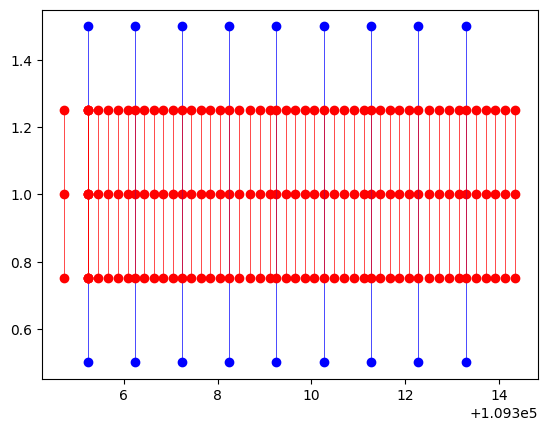

In [11]:
plt.scatter(sync_collector, np.ones_like(sync_collector),c = "r")

for inc in incr_collector:
    plt.plot([inc, inc], [0.5, 1.5],'o-', lw=0.5, c = 'b')
    
for inc in sync_collector:
    plt.plot([inc, inc], [0.75, 1.25],'o-', lw=0.5, c = 'r')
#plt.scatter(incr_collector, 3* np.ones_like(incr_collector),c = "b")

In [12]:
incr_collector

[109305.234,
 109306.234,
 109307.234,
 109308.25,
 109309.25,
 109310.265,
 109311.265,
 109312.281,
 109313.296]

In [13]:
sync_collector

[109304.734,
 109305.234,
 109305.234,
 109305.234,
 109305.234,
 109305.453,
 109305.671,
 109305.875,
 109306.093,
 109306.234,
 109306.437,
 109306.64,
 109306.843,
 109307.046,
 109307.234,
 109307.437,
 109307.64,
 109307.843,
 109308.046,
 109308.25,
 109308.468,
 109308.687,
 109308.906,
 109309.125,
 109309.25,
 109309.453,
 109309.656,
 109309.859,
 109310.062,
 109310.265,
 109310.484,
 109310.687,
 109310.906,
 109311.125,
 109311.265,
 109311.468,
 109311.671,
 109311.875,
 109312.078,
 109312.281,
 109312.5,
 109312.718,
 109312.937,
 109313.156,
 109313.296,
 109313.5,
 109313.718,
 109313.921,
 109314.125,
 109314.343]